# DSCI 100 Final Report

Team: Nicolas Mercuri, Tayler Whitehead

# Part 1: Introduction

Music plays a huge role in our experience of the world around us. Daily tasks like walking through campus, working on homework assignments, or simply cooking dinner after a long day, are a lot more enjoyable while listening to your favourite playlist.

For our group project this semester, we decided to work with a dataset called [Spotify Tracks DB](https://tinyurl.com/3dnwcpe2). This dataset was downloaded from Kaggle.com and was parsed using Spotify's official API. The dataset has over 110,000 unique observations (tracks) and features 18 relevant variables, each describing a specific qualitative or quantitative characteristic of a track.

For our predictive question, we are asking if specific quantitative characteristics of a track (danceability, energy, tempo) can help predict a new song's popularity on the music streaming service, Spotify.

While we acknowledge that there is also an array of qualitative factors that contribute to a song's popularity such as culture, seasonality, and personal preference, and therefore must not be dismissed, these qualitative factors affect a song's popularity following its release (Lee & Lee, 2018). Our analysis, then, offers the opportunity to explore how quantitative variables can potentially play a role in predicting the popularity of a song before its initial release. 

# Part 2: Methods and Results

## Reading in Raw Data

First, we load any necessary packages required for our data cleaning and wrangling, initial anlyses, and visualizations. Then we read in our chosen dataset from our GitHub repository.

In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

options(repr.plot.width= 30, repr.plot.height= 10)

We then read in our chosen dataset from our GitHub repository. In order to ensure that our analyses are reproducible, we used the set.seed function (set to an arbritrary number) to generate the same random selection of data throughout our analysis to maintain consistent results.

In [6]:
set.seed(2022)

spotify_raw_data = read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


## Slicing Data

As our dateset is quite sizable, we decided to cut our data in half to 50,000 observations. This will enable our analysis to minimize wasted time processing code while still maintaining a considerable amount of information for training and testing our regression model.

In [7]:
spotify_sliced = slice_sample(spotify_raw_data, n = 50000)

After slicing our data set, we perform some data wrangling to select only our desired columns (popularity, danceability, and energy), as well as omitting any "NA" values that may interfere with our data analysis. These steps help clean up the data by removing any values that are unnecessary for our particular analysis. 

We also created popularity "buckets" from 1 to 4, which represent a given song's popularity. Creating these buckets enable us to create visualizations using both predictor variables in order to se if any trends are present.

In [8]:
spotify_wrangled = spotify_sliced %>%
                    select(popularity, danceability, energy) %>%
                    na.omit(spotify_wrangled) %>%
                    mutate(popularity_group = case_when(popularity >= 0  & popularity <= 25 ~ '0 <= 25',
                                                        popularity >= 26  & popularity <= 50 ~ '26 <= 50',
                                                        popularity >= 51  & popularity <= 75 ~ '51 <= 75',
                                                        popularity >= 76  & popularity <= 100 ~ '76 <= 100'))

From here, we slice a small sample (n = 1000) of the entire dataset and create a scatter plot to determine if there are any trends we can extrapolate from the plot.

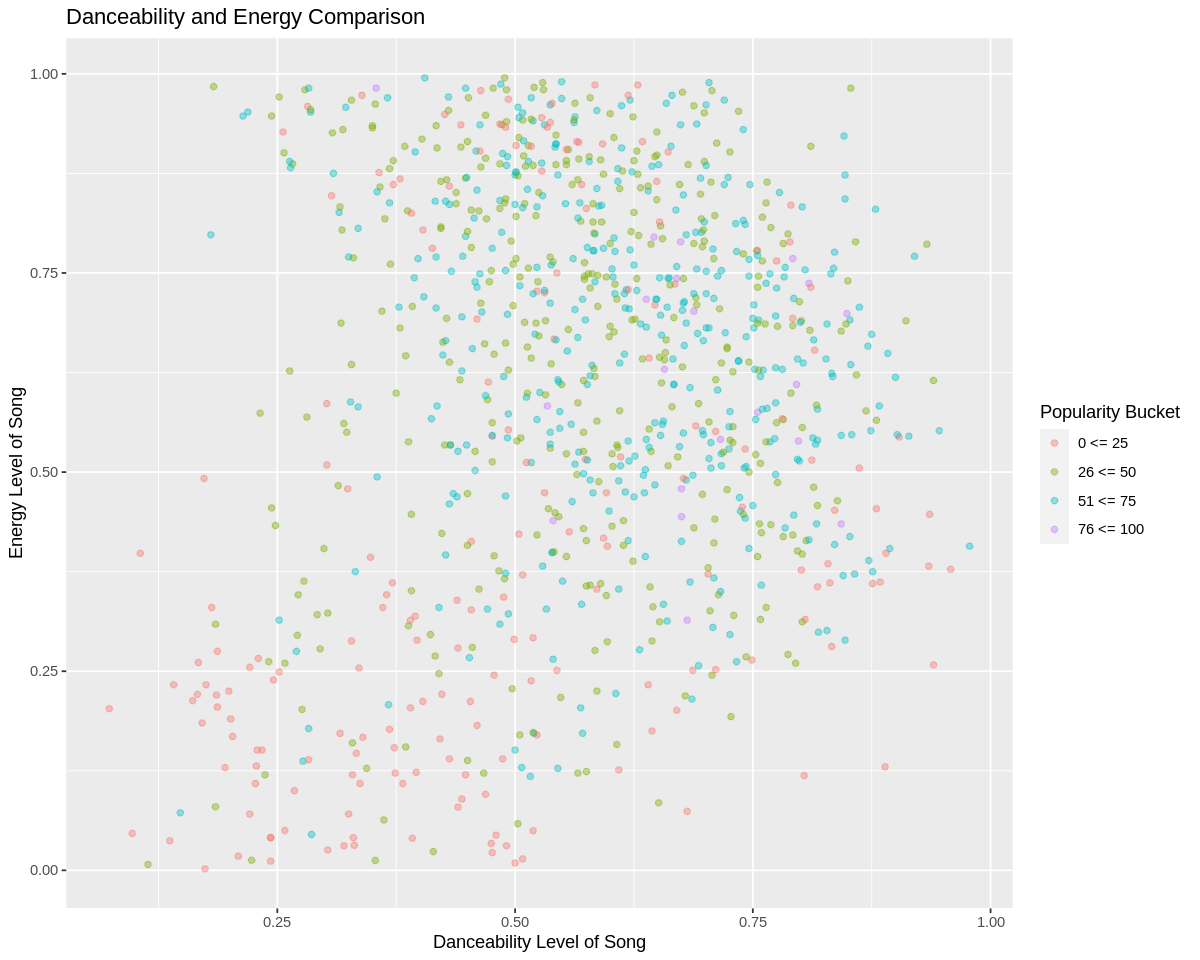

In [9]:
options(repr.plot.width= 10, repr.plot.height= 8)

spotify_really_small = slice_sample(spotify_wrangled, n = 1000)

danceability_vs_popularity = spotify_really_small %>%
                            ggplot(aes(x = danceability, y = energy, color = popularity_group)) + 
                            geom_point(alpha = 0.4) + 
                            labs(y = "Energy Level of Song", x = "Danceability Level of Song", color = "Popularity Bucket") +
                            ggtitle("Danceability and Energy Comparison")
                                   
danceability_vs_popularity                         

From the visualization, we can see that the most unpopular tracks (0 <= 25) tend to cluster in the bottom left quadrant of the graph (danceability and energy levels < 0.50). However, after that it is difficult to make any meaningful conclusions.

### Creating Training Data

Now that we have our relevant popularity buckets, we can create our training dataset which comprises 75% of the total wrangled Spotify dataset. The remaining 25% will be used as our testing dataset.

In [10]:
spotify_split = initial_split(spotify_wrangled, prop = 0.75, strata = popularity)

spotify_train = training(spotify_split)
spotify_test = testing(spotify_split)

### Summarizing the Data

Here we provide the summary statistics of all the quantitative variables included in the dataset. It should be noted, however, that our analysis will only be referring to the following variables: popularity, danceability, energy, and tempo where popularity is measured on a scale from 0-100, danceability and energy have been standardized to a scale of 0-1. 

In [11]:
summary(spotify_train)

   popularity      danceability        energy         popularity_group  
 Min.   :  0.00   Min.   :0.0592   Min.   :0.000243   Length:37501      
 1st Qu.: 30.00   1st Qu.:0.4500   1st Qu.:0.408000   Class :character  
 Median : 47.00   Median :0.5760   Median :0.616000   Mode  :character  
 Mean   : 42.78   Mean   :0.5661   Mean   :0.585922                     
 3rd Qu.: 57.00   3rd Qu.:0.6960   3rd Qu.:0.795000                     
 Max.   :100.00   Max.   :0.9890   Max.   :0.999000                     

### Visualizing the Data

To visualize our data, we will create histograms to show the distribution of values of our main predictive variables: danceability, energy, and tempo.

In [12]:
# danceability_histogram = spotify_train %>%
#                         ggplot(aes(x = danceability, fill = popularity_group)) +
#                         geom_histogram() +
#                         labs(x = "Distribution of Danceability Values (Standardized)", y = "Count of Values"
#                             , fill = "Is This Song Popular?") + 
#                         ggtitle("Danceability Histogram") +
#                         theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) + 
#                         scale_fill_brewer(palette = "Set1")
                        
# energy_histogram = spotify_train %>%
#                         ggplot(aes(x = energy, fill = popularity_group)) +
#                         geom_histogram() +
#                         labs(x = "Distribution of Energy Values (Standardized)", y = "Count of Values"
#                              , fill = "Is This Song Popular?") + 
#                         ggtitle("Energy Histogram") +
#                         theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) + 
#                         scale_fill_brewer(palette = "Set1")

# plot_grid(danceability_histogram, energy_histogram, ncol = 2)

We can see that the danceability and tempo values follow a normal distribution, while the energy distributions are skewed to the right. Additionally, the distribution of popular songs within danceability and energy also skew to the right while within tempo, the distribution is skewed right.

**How will we coduct our data analysis? NEED TO REVISE THIS FOR REGRESSION**

Our data analysis will adhere to the following structure and format:
- Step #1 - Split the data into a training and testing data, respectively. We'll be careful to use relevant proportions of the total data for each set.
- Step #2 - Develop our KNN recipe.
- Step #3 - Build our nearest neighbors model specification, ensuring that the neighbors parameter is set to tune().
- Step #4 - Utilize the vfold_cv function to split our training data for cross-validation.
- Step #5 - Create workflow using the recipe and model developed in steps 3 and 4.
- Step #6 - Choose an optimal K value from this workflow analysis.
- Step #7 - Develop a new model specification using the optimal value for K, and then retrain the regression model using fit.
- Step #8 - Evaluate accuracy using the testing data.
- Step #9 - Develop some visualizations that summarize our analysis, and draft any documentation required to aid understanding of our processes.

**Which variables are most important for our analysis?**

We expect to rely primarily on the following quantitative variables to predict popularity: danceability, and energy. 

**How will we visualize results?**

As our prediction algorithm will be dealing with quantitative data, a scatterplot will be useful for visualizing the datapoints within our dataset. The scatterplot will have one of the three chosen metrics (danceability, energy) on the x-axis and another on the y-axis. Furthermore, we will colour the data points to indicate which popularity bucket a new song will fall into.

**Tuning model to find best K value using two predictors**

Here we create our model's recipe using the training data set, where we inidicate the response variable and the desired predictors. In the recipe we also scale and center the data so that the values are being compared using relative scales and metrics to avoid  one or more variables exhibiting disproportionate influence on the model's outputs.

In [13]:
spotify_recipe <- recipe(popularity ~ danceability + energy, data = spotify_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

spotify_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we create the model specifications using the knn algorithm for regression which predicts the response variable's value based on the values of neighbouring points. Since, we want to find the optimal value of neighbours that reduce's our model's RMSE, we set neighbours to "tune()" while we continue to train the model.

In [14]:
knn_tune = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("regression")

From here, we create a 5-fold cross-validation object, and put the recipe and model specification together in a workflow.

In [15]:
spotify_vfold = vfold_cv(spotify_train, v = 5, strata = popularity)

gridvals = tibble(neighbors = seq(from = 1, to = 20, by = 3))

In [16]:
spotify_results <- workflow() %>%
                      add_recipe(spotify_recipe) %>%
                      add_model(knn_tune) %>%
                      tune_grid(resamples = spotify_vfold, grid = gridvals) %>%
                      collect_metrics() %>%
                    filter(.metric == "rmse")

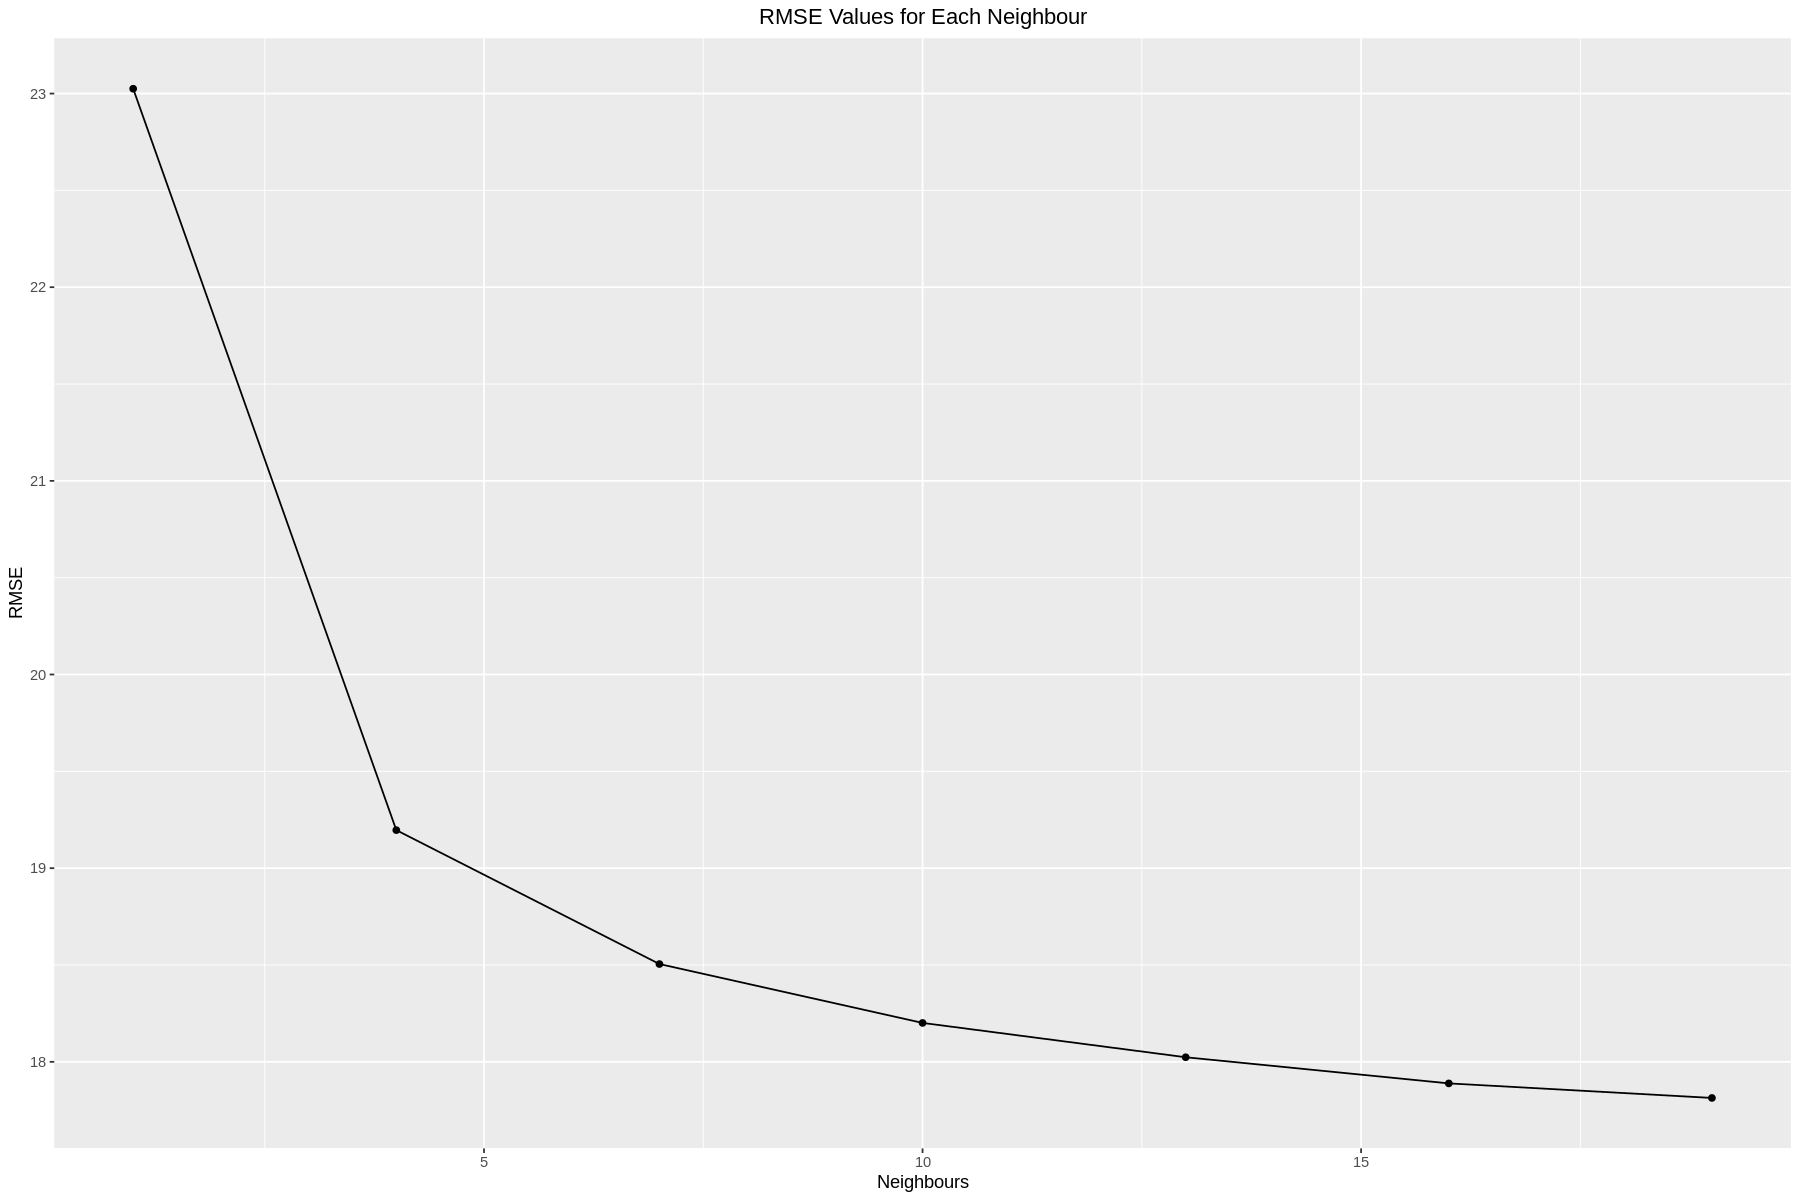

In [17]:
options(repr.plot.width= 15, repr.plot.height= 10)

spotify_results_plot = spotify_results %>% 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbours", y = "RMSE") +
                ggtitle("RMSE Values for Each Neighbour") +
                theme(plot.title = element_text(hjust = 0.5))

spotify_results_plot

In [19]:
spotify_rmse <- spotify_results %>% 
        filter(.metric == "rmse") %>%
        filter(mean == min(mean))

spotify_rmse

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,rmse,standard,17.81345,5,0.01982065,Model7


The RMSE Values for Each Neighbour plot suggests that our RMSE value is minimized when K = 19. This is also confirmed when calculating the min RMSE value in spotify_rmse.

Based on this information, we can be reasonably confident that using 19 neighbours for our knn regression analysis will result in the most precise predictions.

In [20]:
spotify_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) %>%
            set_engine("kknn") %>%
            set_mode("regression")

spotify_fit = workflow() %>%
            add_recipe(spotify_recipe) %>%
            add_model(spotify_spec) %>%
            fit(data = spotify_train)

spotify_summary = predict(spotify_fit, spotify_test) %>%
                bind_cols(spotify_test) %>%
                metrics(truth = popularity, estimate = .pred) %>%
                filter(.metric == "rmse") 

In [213]:
spotify_preds = tibble(energy = seq(from = 1, to = 100, by = 1),
                       danceability = seq(from = 1, to = 100, by = 1))

spotify_preds <- spotify_fit %>%
  predict(spotify_preds) %>%
  bind_cols(spotify_preds)

spotify_preds

.pred,energy,danceability
<dbl>,<dbl>,<dbl>
43.94737,1,1
45.00000,2,2
45.00000,3,3
45.00000,4,4
45.00000,5,5
45.00000,6,6
45.00000,7,7
45.00000,8,8
45.00000,9,9


How do we create useful visualizations?

rmse = 19.13702 with just danceability
rmse = 18.2 with just energy